## Display the xml element tree

In [ ]:
from pptlayout.extractors.run_extractors import run_extractors
from json import dumps
# Replace with your actual PPTX file path
pptx_path = "/data/tianyuhu/PPTLayout/data/pptx/ZK7FNUZ33GBBCG7CFVYS56TQCTD72CJR.pptx"

# Run extractors
info = run_extractors(pptx_path, "emu")
print(dumps(info, indent=4))

In [ ]:
from pptlayout.llm.call_ollama import generate_slide_layout_suggestions
from pptlayout.llm.prompts import build_slide_layout_suggestion_prompts
from tqdm import tqdm
import os
# Call OLLAMA
output_dir = os.path.join(os.curdir, "test_output")
suggestions_list = []
for slide_info in tqdm(info["slides"]):
    slide_id = slide_info["slide_id"]
    slide_output_dir = os.path.join(output_dir, f"{slide_id}")
    if os.path.exists(os.path.join(slide_output_dir, "suggestions.txt")):
        with open(os.path.join(slide_output_dir, "suggestions.txt"), "r") as f:
            suggestions = f.read()
        suggestions_list.append(suggestions)
        continue
    prompt = build_slide_layout_suggestion_prompts(
        json_input=slide_info, 
        slide_width=info["slide_width"],
        slide_height=info["slide_height"]
        )
    suggestions = generate_slide_layout_suggestions(
        model_name="llama3.1:70b",
        prompt=prompt,
        temperature=0.5,
        )
    suggestions_list.append(suggestions)
    # save
    os.makedirs(slide_output_dir, exist_ok=True)
    with open(os.path.join(slide_output_dir, "suggestions.txt"), "w") as f:
        f.write(suggestions)

100%|██████████| 14/14 [00:00<00:00, 60.45it/s]


In [33]:
from pptlayout.llm.parser import extract_json
json_list = []
for suggestions in suggestions_list:
    json_data = extract_json(suggestions)
    json_list.append(json_data)

{   "slide_id": 256,   "slide_name": "",   "shapes": [     {       "name": "PlaceHolder 1",       "shape_id": 22,       "shape_type": "PLACEHOLDER",       "measurement_unit": "emu",       "height": 2228760,       "width": 7772400,       "left": 685800,       "top": 1200000,        "text": "Design for a 2 MW graphite target\x0b\x0bfor a neutrino beam",       "placeholder_type": "TITLE"     },     {       "name": "PlaceHolder 2",       "shape_id": 23,       "shape_type": "PLACEHOLDER",       "measurement_unit": "emu",       "height": 1752480,       "width": 8153640,       "left": 380520,       "top": 4200000,        "text": "Jim Hylen\n\nAccelerator Physics and Technology Workshop for Project X\x0bNovember 12-13, 2007",       "placeholder_type": "SUBTITLE"     }   ] }
{   "slide_id": 257,   "slide_name": "",   "shapes": [     {       "name": "PlaceHolder 1",       "shape_id": 24,       "shape_type": "PLACEHOLDER",       "measurement_unit": "emu",       "height": 533520,       "width": 64

In [34]:
from json import dumps

# print(dumps(json_list[12], indent=4))
for json in json_list:
    print(json)

{'slide_id': 256, 'slide_name': '', 'shapes': [{'name': 'PlaceHolder 1', 'shape_id': 22, 'shape_type': 'PLACEHOLDER', 'measurement_unit': 'emu', 'height': 2228760, 'width': 7772400, 'left': 685800, 'top': 1200000, 'text': 'Design for a 2 MW graphite target\\x0b\\x0bfor a neutrino beam', 'placeholder_type': 'TITLE'}, {'name': 'PlaceHolder 2', 'shape_id': 23, 'shape_type': 'PLACEHOLDER', 'measurement_unit': 'emu', 'height': 1752480, 'width': 8153640, 'left': 380520, 'top': 4200000, 'text': 'Jim Hylen\\n\nAccelerator Physics and Technology Workshop for Project X\\x0bNovember 12-13, 2007', 'placeholder_type': 'SUBTITLE'}]}
{'slide_id': 257, 'slide_name': '', 'shapes': [{'name': 'PlaceHolder 1', 'shape_id': 24, 'shape_type': 'PLACEHOLDER', 'measurement_unit': 'emu', 'height': 533520, 'width': 6477120, 'left': 1523880, 'top': 228960, 'text': 'Introduction', 'placeholder_type': 'TITLE'}, {'name': 'PlaceHolder 2', 'shape_id': 25, 'shape_type': 'PLACEHOLDER', 'measurement_unit': 'emu', 'height'

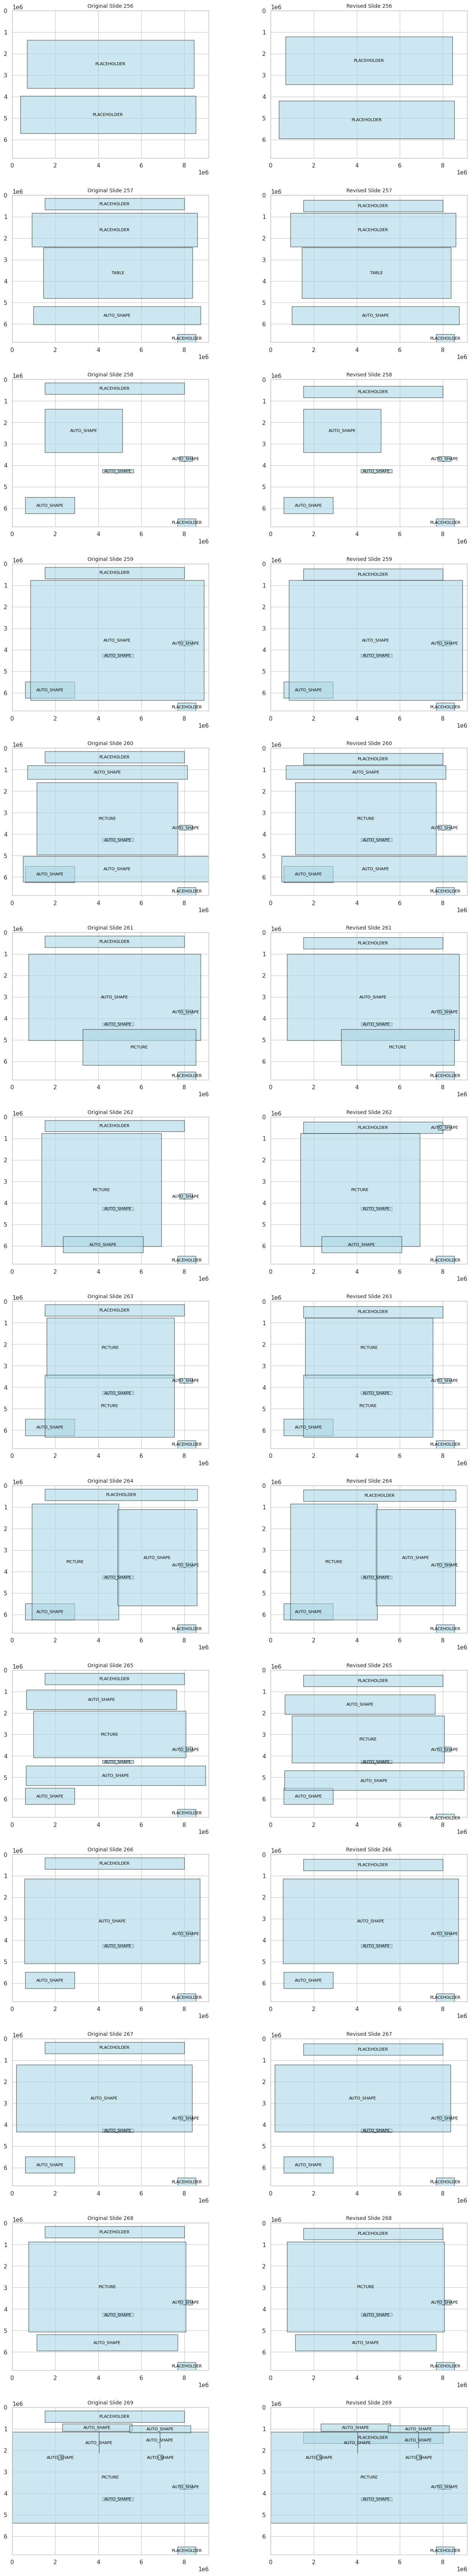

In [35]:
from pptlayout.visualizers.layout_visualizer import generate_comparison_grid

slides = info["slides"]
# Generate comparison grid
comparison_grid = generate_comparison_grid(
    slides,
    json_list,
    slide_width=info["slide_width"],
    slide_height=info["slide_height"]
    )

In [4]:
from pptlayout.llm.call_ollama import generate_slide_layout_suggestions
test_image = "/data/tianyuhu/PPTLayout/notebooks/test_input/image.png"
import ollama
# Call OLLAMA
response = ollama.chat(
    model='llama3.2-vision:11b',
    messages=[{
        'role': 'user',
        'content': 'Please give me a detailed layout suggestion for this slide.',
        'images': [test_image]
    }]
)["message"]["content"]

print(response)


Here is one possible layout suggestion for this slide:

**Title Section**

* **Slide Title:** "NuMI baffle as prototype of target"
	+ Font: Arial or Helvetica, size 18-20 points
	+ Color: Blue (e.g., royal blue or navy blue)
* **Logo:** University of Chicago logo (top-left corner)
	+ Size: Approximately 1/4 to 1/3 the height of the title

**Image Section**

* **Baffle Image:** A photograph of a NuMI baffle, centered on the slide
	+ Size: Approximately 60-70% of the slide's width and height
* **Caption:** Brief description of the image (below the image)
	+ Font: Arial or Helvetica, size 10-12 points
	+ Color: Black

**Text Section**

* **Subtitle:** "Graphite is good in compression, poor in tension, so put pre-stress at outer radius by encapsulating in aluminum or steel"
	+ Font: Arial or Helvetica, size 14-16 points
	+ Color: Black
* **Paragraphs:**
	+ First paragraph (below the subtitle):
		- Text: "Existing NuMI baffle is 1.5 m long, 6 cm diameter graphite encapsulated in aluminum"
	

In [ ]:
import aspose.slides as slides

pres = slides.Presentation("/data/tianyuhu/PPTLayout/data/pptx/ZK7FNUZ33GBBCG7CFVYS56TQCTD72CJR.pptx")
out_dir = "/data/tianyuhu/PPTLayout/notebooks/test_output/jpg"
for sld in pres.slides:
    with sld.get_image(1, 1) as bmp:
        bmp.save("{out_dir}/Slide_{num}.jpg".format(out_dir=out_dir, num=str(sld.slide_number)), slides.ImageFormat.JPEG)
